Se importan los paquetes necesarios:

In [ ]:
!pip install scikit-plot

Para obtener resultados reproducibles:

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import statistics
import itertools
from prettytable import PrettyTable
from tqdm import tqdm
import scikitplot as skplt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Mounted at /content/drive


Ubicación de los datasets:

In [ ]:
DS1 = ['/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_x_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_x_test.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_y_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_y_test.csv']

DS2 = ['/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_x_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_x_test.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_y_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_y_test.csv']

DS3 = ['/content/drive/Shareddrives/TFM-JRA/data/DS/DS3_x_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS3_y_train.csv']

In [ ]:
# DS1
DS1_x_train = pd.read_csv(DS1[0])
DS1_x_test = pd.read_csv(DS1[1])
DS1_y_train = pd.read_csv(DS1[2])
DS1_y_test = pd.read_csv(DS1[3])

# DS2
DS2_x_train = pd.read_csv(DS2[0])
DS2_x_test = pd.read_csv(DS2[1])
DS2_y_train = pd.read_csv(DS2[2])
DS2_y_test = pd.read_csv(DS2[3])

# DS3. En este caso solo han cambiado los conjuntos train respecto a DS2
DS3_x_train = pd.read_csv(DS3[0])
DS3_x_test = DS2_x_test
DS3_y_train = pd.read_csv(DS3[1])
DS3_y_test = DS2_y_test

Funciones auxiliares:

In [ ]:
# Función de coste
def cost_function(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  fp = cm[0][1]
  fn = cm[1][0]

  total_cost = fp * 10 + fn * 500
  return total_cost

Creación de un objeto de tipo `score` para validación cruzada

In [ ]:
score = make_scorer(cost_function, greater_is_better=False)

# 1. **DS1**

## 1.1. Red Neuronal

Elección de hiperparámetros.

In [ ]:
batch_sizes = [64,128,256,512,1024]
epochs = [120]
layers = [1,2]
neurons = [8,10,12]

x = PrettyTable()
x.field_names = ["batch_size", "epochs", "Número de capas", "Neuronas/capa", "Coste"]

# Se exploran todas las combinaciones con los valores anteriores
for batch_size in batch_sizes:
  for epoch in epochs:
    for layer in layers:
      for neuron in neurons:

        results = []

        # Se entrena el modelo 16 veces
        for i in range(16):

          if layer == 1:
            # Una capa
            def create_model():
              model = Sequential()
              model.add(Dense(neuron, input_dim=DS1_x_train.shape[1], kernel_initializer='normal', activation='relu'))
              model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
              model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
              return model
          else:
            # Dos capas
            def create_model():
              model = Sequential()
              model.add(Dense(neuron, input_dim=DS1_x_train.shape[1], kernel_initializer='normal', activation='relu'))
              model.add(Dense(neuron, kernel_initializer='normal', activation='relu'))
              model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
              model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
              return model

          estimators = []
          # Se estandarizan las características eliminando la media y escalando a la varianza unitaria
          estimators.append(('standardize', StandardScaler()))
          # KerasClassifier
          estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, verbose=0)))
          # Pipeline de transformaciones con un estimador final
          pipeline = Pipeline(estimators)

          threshold = 0.5
          prediction = pipeline.fit(DS1_x_train, DS1_y_train)
          DS1_pred_nn = pipeline.predict_proba(DS1_x_test)[:,1] > threshold

          coste = cost_function(DS1_y_test, DS1_pred_nn)
          results.append(coste)
        
        print(results)
        x.add_row([batch_size, epoch, layer, neuron, statistics.mean(results)])
        print(x)
      
      x.add_row(['**********', '******', '***************', '*************', '*****'])

print(x)

Los resultados anteriores han sido almacenados en un archivo *.csv*. A continuación se leen para analizarlos:

In [ ]:
data = pd.read_excel('/content/drive/Shareddrives/TFM-JRA/data/NN_DS1.xlsx')
data

,batch_size,epochs,capas,neuronas,coste_media
0,64,120,1,8,55626
1,64,120,1,10,54547
2,64,120,1,12,52648
3,64,120,2,8,55636
4,64,120,2,10,56560
5,64,120,2,12,57252
6,128,120,1,8,50766
7,128,120,1,10,52943
8,128,120,1,12,54032
9,128,120,2,8,53511


### 1. Análisis sobre el tamaño del *batch*.

In [ ]:
df1 = data.groupby('batch_size')['coste_media'].apply(list).reset_index(name='costs')
df1['costs']

0    [55626, 54547, 52648, 55636, 56560, 57252]
1    [50766, 52943, 54032, 53511, 57388, 53776]
2    [48240, 50676, 54175, 54567, 54040, 55882]
3    [46828, 44711, 48540, 55373, 50170, 53238]
4    [50730, 52852, 52057, 49496, 53446, 53368]
Name: costs, dtype: object

Variación del coste en función del resto de parámetros para los distintos tamaños de *batch*:

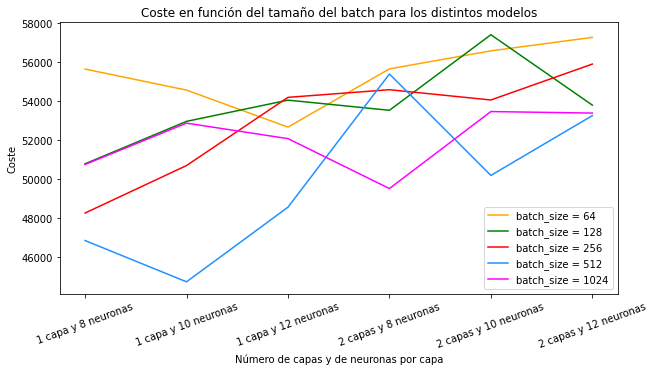

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(list(range(1,7)), df1['costs'][0], color='orange', label='batch_size = 64')
ax.plot(list(range(1,7)), df1['costs'][1], color='green', label='batch_size = 128')
ax.plot(list(range(1,7)), df1['costs'][2], color='red', label='batch_size = 256')
ax.plot(list(range(1,7)), df1['costs'][3], color='dodgerblue', label='batch_size = 512')
ax.plot(list(range(1,7)), df1['costs'][4], color='magenta', label='batch_size = 1024')

ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['', '1 capa y 8 neuronas', '1 capa y 10 neuronas', '1 capa y 12 neuronas',
          '2 capas y 8 neuronas', '2 capas y 10 neuronas', '2 capas y 12 neuronas']
ax.set_xticklabels(labels, rotation=20)

ax.set_xlabel("Número de capas y de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del tamaño del batch para los distintos modelos")
plt.show()

### 2. Análisis sobre el número de capas.

In [ ]:
df2 = data.groupby('capas')['coste_media'].apply(list).reset_index(name='costs')
df2['costs']

0    [55626, 54547, 52648, 50766, 52943, 54032, 482...
1    [55636, 56560, 57252, 53511, 57388, 53776, 545...
Name: costs, dtype: object

Variación del coste en función del resto de parámetros para los distintos números de capas:

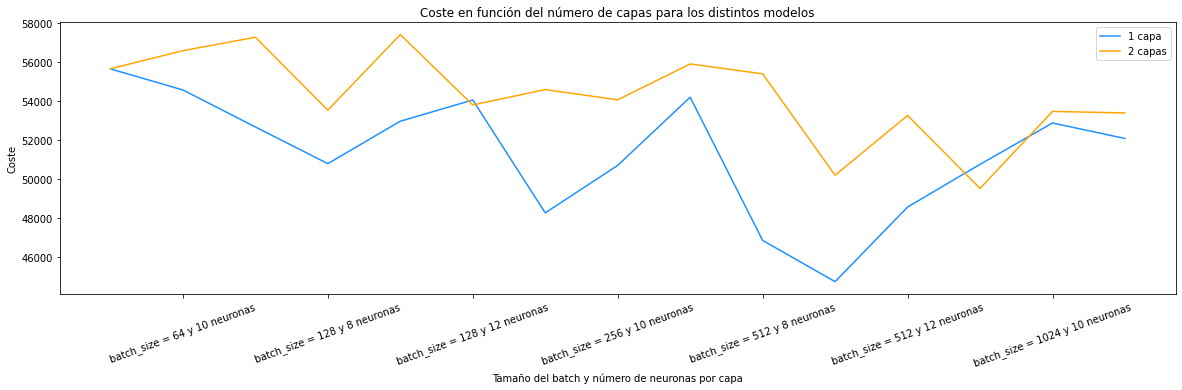

In [ ]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(list(range(1,16)), df2['costs'][0], color='dodgerblue', label='1 capa')
ax.plot(list(range(1,16)), df2['costs'][1], color='orange', label='2 capas')

ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['', 'batch_size = 64 y 10 neuronas', 'batch_size = 128 y 8 neuronas',
          'batch_size = 128 y 12 neuronas', 'batch_size = 256 y 10 neuronas',
          'batch_size = 512 y 8 neuronas', 'batch_size = 512 y 12 neuronas',
          'batch_size = 1024 y 10 neuronas']
ax.set_xticklabels(labels, rotation=20)

ax.set_xlabel("Tamaño del batch y número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de capas para los distintos modelos")
plt.show()

### 3. Análisis sobre el número de neuronas por capa.

In [ ]:
df3 = data.groupby('neuronas')['coste_media'].apply(list).reset_index(name='costs')
df3['costs']

0    [55626, 55636, 50766, 53511, 48240, 54567, 468...
1    [54547, 56560, 52943, 57388, 50676, 54040, 447...
2    [52648, 57252, 54032, 53776, 54175, 55882, 485...
Name: costs, dtype: object

Variación del coste en función del resto de parámetros para los distintos números de neuronas por capa:

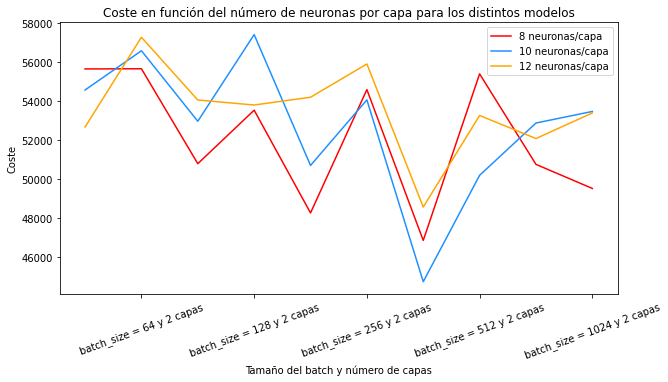

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(list(range(1,11)), df3['costs'][0], color='red', label='8 neuronas/capa')
ax.plot(list(range(1,11)), df3['costs'][1], color='dodgerblue', label='10 neuronas/capa')
ax.plot(list(range(1,11)), df3['costs'][2], color='orange', label='12 neuronas/capa')

ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['', 'batch_size = 64 y 2 capas', 'batch_size = 128 y 2 capas',
          'batch_size = 256 y 2 capas', 'batch_size = 512 y 2 capas',
          'batch_size = 1024 y 2 capas']
ax.set_xticklabels(labels, rotation=20)

ax.set_xlabel("Tamaño del batch y número de capas")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de neuronas por capa para los distintos modelos")
plt.show()

Con los resultados obtenidos se genera el modelo que se muestra a continuación:

### 4. Modelo base.

In [ ]:
batch_size = 512
epochs = 120

def create_model():
  model = Sequential()
  model.add(Dense(10, input_dim=DS1_x_train.shape[1], kernel_initializer='normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
  # Compilación del modelo. Se emplea una función de pérdida logarítmica y el optimizador de gradiente Adam.
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Se evalua el modelo utilizando el conjunto de datos *DS1* 

In [ ]:
estimators = []
# Se estandarizan las características eliminando la media y escalando a la varianza unitaria
estimators.append(('standardize', StandardScaler()))
# KerasClassifier
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)))
# Pipeline de transformaciones con un estimador final
pipeline = Pipeline(estimators)

# Cross validation.
# Se utiliza StratifiedKFold al ser un dataset muy desbalanceado
# https://towardsdatascience.com/how-to-train-test-split-kfold-vs-stratifiedkfold-281767b93869
kfold = StratifiedKFold(n_splits=10, shuffle=True)
# Se evalua el modelo mediante validación cruzada
results = cross_val_score(pipeline, DS1_x_train, DS1_y_train, cv=kfold)

# Media de los resultados junto a la desviación estándar
print("Resultados: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Resultados: 99.21% (0.12%)


Se ajusta el modelo utilizando el conjunto de datos de entrenamiento y se predicen los resultados utilizando el conjunto de datos de prueba.

In [ ]:
prediction = pipeline.fit(DS1_x_train, DS1_y_train)

# Umbral
threshold = 0.5
DS1_pred_nn = pipeline.predict_proba(DS1_x_test)[:,1] > threshold

accuracy = accuracy_score(DS1_y_test, DS1_pred_nn)
print("Accuracy: %.2f%% " % (accuracy.mean()*100))

Accuracy: 99.01% 


In [ ]:
# Classification report
print(classification_report(DS1_y_test, DS1_pred_nn))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     15625
        True       0.80      0.77      0.79       375

    accuracy                           0.99     16000
   macro avg       0.90      0.88      0.89     16000
weighted avg       0.99      0.99      0.99     16000



Medidas sobre los conjuntos de entrenamiento y prueba:

In [ ]:
DS1_pred_rf_train = pipeline.predict_proba(DS1_x_train)[:,1] > 0.5
print("Pérdida en los datos de entrenamiento:", cost_function(DS1_y_train, DS1_pred_rf_train))
print("Precisión (precision) en los datos de entrenamiento:", np.round(precision_score(DS1_y_train, DS1_pred_rf_train), 4))
print("Sensibilidad (recall) en los datos de entrenamiento:", np.round(recall_score(DS1_y_train, DS1_pred_rf_train), 4))
print("Valor-F1 (F1-score) en los datos de entrenamiento:", np.round(f1_score(DS1_y_train, DS1_pred_rf_train), 4))

DS1_pred_rf = pipeline.predict_proba(DS1_x_test)[:,1] > 0.5
print("\nPérdida en los datos de prueba:", cost_function(DS1_y_test, DS1_pred_rf))
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS1_y_test, DS1_pred_rf), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS1_y_test, DS1_pred_rf), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS1_y_test, DS1_pred_rf), 4))

Pérdida en los datos de entrenamiento: 70360
Precisión (precision) en los datos de entrenamiento: 0.8637
Sensibilidad (recall) en los datos de entrenamiento: 0.862
Valor-F1 (F1-score) en los datos de entrenamiento: 0.8629

Pérdida en los datos de prueba: 43230
Precisión (precision) en los datos de prueba: 0.7989
Sensibilidad (recall) en los datos de prueba: 0.7733
Valor-F1 (F1-score) en los datos de prueba: 0.7859


Matriz de confusión para el umbral por defecto de 0,5:

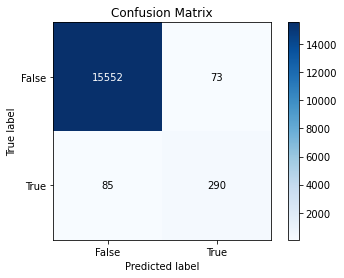

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS1_y_test, DS1_pred_nn, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS1_y_test, DS1_pred_nn))

Coste total del modelo: 43230


Aunque la *accuracy* es superior al 99%, el coste total del modelo es muy elevado.

Es necesario tratar con los umbrales de probabilidad que están establecidos en 0,5 por defecto. Al tener un desequilibrio de clases tan alto, no es adecuado trabajar con el umbral por defecto de 0,5, ya que de esta forma se está dando el mismo peso a ambas clases, lo que funciona bien cuando estas están equilibradas. En este problema, los datos están muy desequilibrados por lo que es conveniente hacer frente a esto cambiando la probabilidad de corte.

In [ ]:
# Dataframe con las predicciones y la probabilidad predicha
pred = pipeline.predict_proba(DS1_x_test)[:,1]

prob_df = pd.DataFrame({"actual": DS1_y_test['class'],
                        "prediction": DS1_pred_nn,
                        "prob": pred,
                        })

prob_df

,actual,prediction,prob
0,False,False,0.000272
1,False,False,0.000033
2,False,False,0.000016
3,False,False,0.000032
4,False,False,0.000020
...,...,...,...
15995,False,False,0.000765
15996,False,False,0.000023
15997,False,False,0.000049
15998,False,False,0.000103


Gráfico de distribución de probabilidad.

Este gráfico sirve para identificar si hay un solapamiento entre las distribuciones de clase de la probabilidad predicha para los datos de prueba.

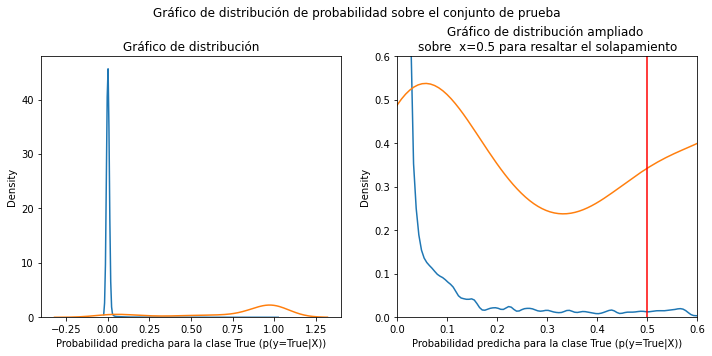

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.kdeplot(prob_df.loc[prob_df["actual"] == False, "prob"], label = "False", ax= axes[0])
sns.kdeplot(prob_df.loc[prob_df["actual"] == True, "prob"], label = "True", ax= axes[0])
axes[0].set_xlabel("Probabilidad predicha para la clase True (p(y=True|X))")
axes[0].set_title("Gráfico de distribución")

sns.kdeplot(prob_df.loc[prob_df["actual"] == False, "prob"], label = "False", ax= axes[1])
sns.kdeplot(prob_df.loc[prob_df["actual"] == True, "prob"], label = "True", ax= axes[1])
plt.plot([0.5,0.5], [0,0.6],  color='red')  # Línea vertical para mostrar el umbral por defecto para la asignación de clases
axes[1].set_xlim(0,0.6)
axes[1].set_ylim(0,0.6)
axes[1].set_xlabel("Probabilidad predicha para la clase True (p(y=True|X))")
axes[1].set_title("\nGráfico de distribución ampliado \nsobre  x=0.5 para resaltar el solapamiento")

fig.suptitle("Gráfico de distribución de probabilidad sobre el conjunto de prueba")
plt.tight_layout()

plt.show()

Y se elige el mejor umbral por *cross-validation*:

In [ ]:
k_folds = 3

cv_size = DS1_x_train.shape[0]//k_folds
thresholds = np.arange(0.01,0.08,0.01)
K_fold_loss = []
for threshold in tqdm(thresholds):
    loss = 0
    start_idx = 0
    for k in range(k_folds):
        end_idx = start_idx+cv_size
        cv_idx = random.sample(range(DS1_x_train.shape[0]), k=cv_size)
        train_idx = [x for x in np.arange(DS1_x_train.shape[0]) if x not in cv_idx]
        
        # Se dividen los datos
        X_cv = DS1_x_train.iloc[cv_idx].copy()
        y_cv = DS1_y_train.iloc[cv_idx].copy()

        x_tr = DS1_x_train.iloc[train_idx].copy()
        y_tr = DS1_y_train.iloc[train_idx].copy()
        
        # Modelo
        pipeline.fit(x_tr, y_tr)
        
        # Predicción basada en el umbral
        pred = np.zeros(cv_size)
        prob = pipeline.predict_proba(X_cv)[:,1]
        pred[prob > threshold] = 1
        print(loss, cost_function(y_pred=pred, y_true=y_cv))
        loss += cost_function(y_pred=pred, y_true=y_cv)
        start_idx = end_idx
    
    print(loss)
    K_fold_loss.append(loss/k_folds)
    print(K_fold_loss)


  0%|          | 0/8 [00:00<?, ?it/s]

0 30650
30650 28710



 12%|█▎        | 1/8 [11:21<1:19:27, 681.01s/it]

59360 20550
79910
[26636.666666666668]
0 26820
26820 22900



 25%|██▌       | 2/8 [24:58<1:12:11, 721.87s/it]

49720 23940
73660
[26636.666666666668, 24553.333333333332]
0 27420
27420 28230



 38%|███▊      | 3/8 [39:10<1:03:25, 761.08s/it]

55650 22850
78500
[26636.666666666668, 24553.333333333332, 26166.666666666668]
0 34420
34420 27790



 50%|█████     | 4/8 [53:06<52:13, 783.38s/it]  

62210 19480
81690
[26636.666666666668, 24553.333333333332, 26166.666666666668, 27230.0]
0 28140
28140 27510



 62%|██████▎   | 5/8 [1:04:40<37:49, 756.64s/it]

55650 31420
87070
[26636.666666666668, 24553.333333333332, 26166.666666666668, 27230.0, 29023.333333333332]
0 29560
29560 34330



 75%|███████▌  | 6/8 [1:15:50<24:21, 730.56s/it]

63890 26190
90080
[26636.666666666668, 24553.333333333332, 26166.666666666668, 27230.0, 29023.333333333332, 30026.666666666668]
0 33610
33610 25730



 88%|████████▊ | 7/8 [1:26:09<11:37, 697.32s/it]

59340 30930
90270
[26636.666666666668, 24553.333333333332, 26166.666666666668, 27230.0, 29023.333333333332, 30026.666666666668, 30090.0]
0 34930
34930 31270



100%|██████████| 8/8 [1:36:25<00:00, 723.17s/it]

66200 35610
101810
[26636.666666666668, 24553.333333333332, 26166.666666666668, 27230.0, 29023.333333333332, 30026.666666666668, 30090.0, 33936.666666666664]


Se representa el coste medio en función del umbral de probabilidad correspondiente.

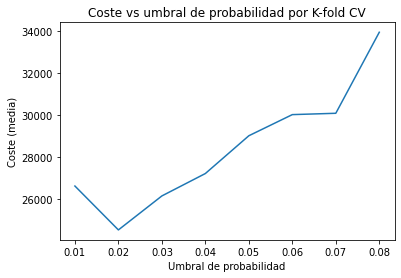

In [ ]:
plt.plot(thresholds, K_fold_loss)
plt.xlabel("Umbral de probabilidad")
plt.ylabel("Coste (media)")
plt.title("Coste vs umbral de probabilidad por K-fold CV")
plt.show()

In [ ]:
# Los valores numéricos son
display(pd.DataFrame(dict({"Thresholds": thresholds,
                            "Average CV Loss": K_fold_loss
                           })))

,Thresholds,Average CV Loss
0,0.01,26636.666667
1,0.02,24553.333333
2,0.03,26166.666667
3,0.04,27230.000000
4,0.05,29023.333333
5,0.06,30026.666667
6,0.07,30090.000000
7,0.08,33936.666667


El umbral óptimo es 0,02.

Se predicen los resultados utilizando el conjunto de datos de prueba y el umbral óptimo.

In [ ]:
# Umbral
threshold = 0.02
DS1_pred_nn = pipeline.predict_proba(DS1_x_test)[:,1] > threshold

accuracy = accuracy_score(DS1_y_test, DS1_pred_nn)
print("Accuracy: %.2f%% " % (accuracy.mean()*100))

Accuracy: 97.39% 


In [ ]:
# Classification report
print(classification_report(DS1_y_test, DS1_pred_nn))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     15625
        True       0.47      0.93      0.62       375

    accuracy                           0.97     16000
   macro avg       0.73      0.95      0.81     16000
weighted avg       0.99      0.97      0.98     16000



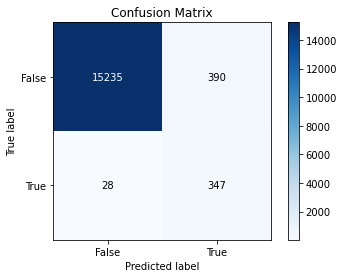

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS1_y_test, DS1_pred_nn, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS1_y_test, DS1_pred_nn))

Coste total del modelo: 17900


Medidas sobre el modelo definitivo:

In [ ]:
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS1_y_test, DS1_pred_nn), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS1_y_test, DS1_pred_nn), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS1_y_test, DS1_pred_nn), 4))
print("Exactitud (accuracy) en los datos de prueba:", np.round(accuracy_score(DS1_y_test, DS1_pred_nn), 4))
print("ROC AUC score en los datos de prueba:", np.round(roc_auc_score(DS1_y_test, DS1_pred_nn), 4))

Precisión (precision) en los datos de prueba: 0.4708
Sensibilidad (recall) en los datos de prueba: 0.9253
Valor-F1 (F1-score) en los datos de prueba: 0.6241
Exactitud (accuracy) en los datos de prueba: 0.9739
ROC AUC score en los datos de prueba: 0.9502


# 2. **DS2**

## 2.1. Red Neuronal

En primer lugar se estandarizan las características utilizando `MinMaxScaler`:

In [ ]:
scaler = MinMaxScaler()
DS2_x_train_scaled = scaler.fit_transform(DS2_x_train)
DS2_x_test_scaled = scaler.transform(DS2_x_test)

Y se transforman los vectores de clase (booleanos) en una matriz de clase binaria.

In [ ]:
DS2_y_train_encode = to_categorical(DS2_y_train)
DS2_y_test_encode = to_categorical(DS2_y_test)

Se estiman los pesos de las clases utilizando `compute_class_weight`:

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(DS2_y_train),
                                                 DS2_y_train['class'])
class_weights_dict = {}
for i in range(len(class_weights)):
  class_weights_dict[i] = class_weights[i]

class_weights_dict

{0: 0.5053812954836846, 1: 46.95721476510067}

### 1. Elección de hiperparámetros.

In [ ]:
layers = [1,2]
neurons = [6, 10, 12, 16, 32, 64, 100, 110, 128]
thresholds = np.arange(0.2,0.65,0.005)

for layer in layers:
  for neuron in neurons:
    
    thres = []
    results = []
    for i in range(8):
      if layer == 1:
        # Una capa
        clf_nn = Sequential()
        clf_nn.add(Dense(neuron, input_shape = (DS2_x_train_scaled.shape[1], ), activation = "relu"))
        clf_nn.add(Dropout(0.5))
        clf_nn.add(Dense(2, activation = "sigmoid"))
      
      else:
        # Dos capas
        clf_nn = Sequential()
        clf_nn.add(Dense(neuron, input_shape = (DS2_x_train_scaled.shape[1], ), activation = "relu"))
        clf_nn.add(Dropout(0.5))
        clf_nn.add(Dense(neuron, activation = "relu"))
        clf_nn.add(Dropout(0.5))
        clf_nn.add(Dense(2, activation = "sigmoid"))
      
      early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
      clf_nn.compile(loss='binary_crossentropy', optimizer=Adam(0.0002), metrics=['accuracy'])
      clf_nn.fit(DS2_x_train_scaled, DS2_y_train_encode,
                 class_weight = class_weights_dict,
                 batch_size=512,
                 epochs= 250,
                 verbose=0,
                 validation_data=(DS2_x_test_scaled, DS2_y_test_encode),
                 callbacks= [early_stopping]
                 )
      
      # Elección del threshold
      costs = []
      for t in thresholds:
        DS2_pred_nn = clf_nn.predict_proba(DS2_x_test_scaled)[:,1] > t
        costs.append(cost_function(DS2_y_test, DS2_pred_nn))
      
      # Umbral
      threshold = round(thresholds[np.argmin(costs)], 3)
      DS2_pred_nn = clf_nn.predict_proba(DS2_x_test_scaled)[:,1] > threshold

      thres.append(threshold)
      res = cost_function(DS2_y_test, DS2_pred_nn)
      results.append(res)
    
    print("Capas:", layer)
    print("Neuronas por capa:", neuron)
    print("Umbrales:", thres)
    print("Resultados:", results)
    print("Mínimo coste (media):", statistics.mean(results))
    print("\n")

Se obtienen los siguientes resultados, donde:

- `res_1_6` hacer referencia a que son los resultados de la red neuronal con una capa y 6 neuronas en la capa oculta.
- `res_1_10` hacer referencia a que son los resultados de la red neuronal con una capa y 10 neuronas en la capa oculta.
- etc.

Las variables cuentan con 9 valores: los 8 primeros son los resultados obtenidos en cada una de las iteraciones y el último valore es la media de los 8 resultados precedentes.

In [ ]:
res_1_6 = [15120, 13240, 13930, 14660, 13740, 13870, 14510, 14540, 14201]
res_1_10 = [12490, 14510, 13730, 12890, 13450, 13110, 14020, 14920, 13640]
res_1_12 = [13390, 12580, 14070, 12970, 14540, 12390, 12830, 14490, 13407]
res_1_16 = [13630, 14150, 13360, 13280, 13520, 13850, 13490, 13240, 13565]
res_1_32 = [14510, 13370, 13550, 14180, 13460, 13460, 13320, 14180, 13753]
res_1_64 = [14410, 14520, 13460, 14220, 14870, 14270, 14350, 13340, 14180]
res_1_100 = [13510, 14550, 13430, 13430, 13490, 14870, 13670, 13860, 13851]
res_1_110 = [13580, 13460, 13440, 14540, 14510, 14110, 13600, 13770, 13876]
res_1_128 = [13550, 14320, 14420, 14090, 14420, 13460, 13860, 13440, 13945]

res_2_6 = [21350, 21700, 18150, 18280, 18470, 16260, 13730, 19340, 18410]
res_2_10 = [18740, 14360, 13940, 26640, 12940, 16150, 18750, 16590, 17263]
res_2_12 = [16510, 17890, 16120, 13800, 16650, 13770, 54570, 13050, 20295]
res_2_16 = [17340, 14480, 17220, 16340, 13830, 15790, 13760, 15720, 15560]
res_2_32 = [15560, 15700, 16250, 11890, 14680, 13040, 14640, 15090, 14606]
res_2_64 = [14870, 15530, 14970, 12810, 13450, 13110, 14320, 14960, 14252]
res_2_100 = [15020, 15550, 15110, 12840, 14170, 13010, 13700, 15120, 14315]
res_2_110 = [15130, 14670, 13510, 14780, 13740, 12750, 13700, 12300, 13822]
res_2_128 = [15610, 13510, 13900, 13750, 15390, 14800, 13420, 15110, 14436]

Se representa el coste en función del número de neuronas para red de una capa. Se muestran en azul los valores obtenidos y en rojo las medias.

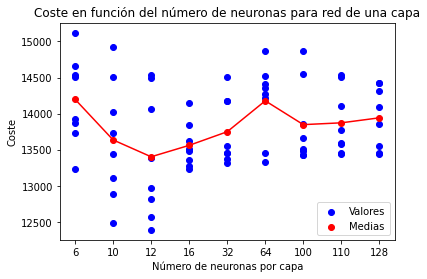

In [ ]:
means_1 = [res_1_6[8], res_1_10[8], res_1_12[8], res_1_16[8],
           res_1_32[8], res_1_64[8], res_1_100[8], res_1_110[8], res_1_128[8]]

fig, ax = plt.subplots()
ax.scatter(list(itertools.repeat(1, 8)), res_1_6[0:8], color='blue')
ax.scatter(list(itertools.repeat(2, 8)), res_1_10[0:8], color='blue')
ax.scatter(list(itertools.repeat(3, 8)), res_1_12[0:8], color='blue')
ax.scatter(list(itertools.repeat(4, 8)), res_1_16[0:8], color='blue')
ax.scatter(list(itertools.repeat(5, 8)), res_1_32[0:8], color='blue')
ax.scatter(list(itertools.repeat(6, 8)), res_1_64[0:8], color='blue')
ax.scatter(list(itertools.repeat(7, 8)), res_1_100[0:8], color='blue')
ax.scatter(list(itertools.repeat(8, 8)), res_1_110[0:8], color='blue')
ax.scatter(list(itertools.repeat(9, 8)), res_1_128[0:8], color='blue', label='Valores')
# Medias
ax.scatter(list(range(1,10)), means_1, color='red', label='Medias')
ax.plot(list(range(1,10)), means_1, color='red')
ax.legend(loc=4)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de neuronas para red de una capa")
plt.show()

Resultados numéricos:

In [ ]:
table = PrettyTable()

table.add_column('Neuronas por capa', [6, 10, 12, 16, 32, 64, 100, 110, 128])
table.add_column('Coste (medio)', means_1)

print(table)

+-------------------+---------------+
| Neuronas por capa | Coste (medio) |
+-------------------+---------------+
|         6         |     14201     |
|         10        |     13640     |
|         12        |     13407     |
|         16        |     13565     |
|         32        |     13753     |
|         64        |     14180     |
|        100        |     13851     |
|        110        |     13876     |
|        128        |     13945     |
+-------------------+---------------+


Se representa el coste en función del número de neuronas para red de dos capas. Se muestran en azul los valores obtenidos y en rojo las medias.

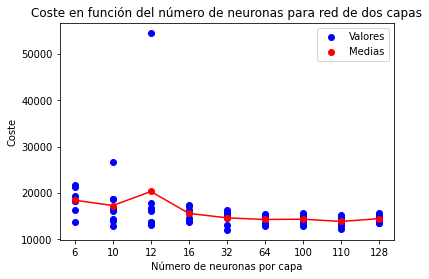

In [ ]:
means_2 = [res_2_6[8], res_2_10[8], res_2_12[8], res_2_16[8],
           res_2_32[8], res_2_64[8], res_2_100[8], res_2_110[8], res_2_128[8]]

fig, ax = plt.subplots()
ax.scatter(list(itertools.repeat(1, 8)), res_2_6[0:8], color='blue')
ax.scatter(list(itertools.repeat(2, 8)), res_2_10[0:8], color='blue')
ax.scatter(list(itertools.repeat(3, 8)), res_2_12[0:8], color='blue')
ax.scatter(list(itertools.repeat(4, 8)), res_2_16[0:8], color='blue')
ax.scatter(list(itertools.repeat(5, 8)), res_2_32[0:8], color='blue')
ax.scatter(list(itertools.repeat(6, 8)), res_2_64[0:8], color='blue')
ax.scatter(list(itertools.repeat(7, 8)), res_2_100[0:8], color='blue')
ax.scatter(list(itertools.repeat(8, 8)), res_2_110[0:8], color='blue')
ax.scatter(list(itertools.repeat(9, 8)), res_2_128[0:8], color='blue', label='Valores')
# Medias
ax.scatter(list(range(1,10)), means_2, color='red', label='Medias')
ax.plot(list(range(1,10)), means_2, color='red')
ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de neuronas para red de dos capas")
plt.show()

Se amplia el gráfico para ocultar la presencia del dato *outlier* y ver mejor los resultados.

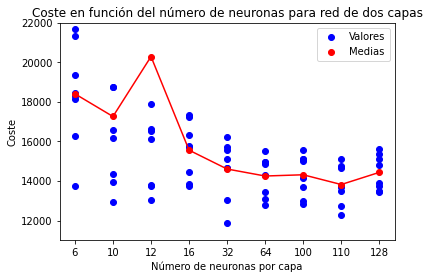

In [ ]:
means_2 = [res_2_6[8], res_2_10[8], res_2_12[8], res_2_16[8], res_2_32[8], res_2_64[8], res_2_100[8], res_2_110[8], res_2_128[8]]

fig, ax = plt.subplots()
ax.scatter(list(itertools.repeat(1, 8)), res_2_6[0:8], color='blue')
ax.scatter(list(itertools.repeat(2, 8)), res_2_10[0:8], color='blue')
ax.scatter(list(itertools.repeat(3, 8)), res_2_12[0:8], color='blue')
ax.scatter(list(itertools.repeat(4, 8)), res_2_16[0:8], color='blue')
ax.scatter(list(itertools.repeat(5, 8)), res_2_32[0:8], color='blue')
ax.scatter(list(itertools.repeat(6, 8)), res_2_64[0:8], color='blue')
ax.scatter(list(itertools.repeat(7, 8)), res_2_100[0:8], color='blue')
ax.scatter(list(itertools.repeat(8, 8)), res_2_110[0:8], color='blue')
ax.scatter(list(itertools.repeat(9, 8)), res_2_128[0:8], color='blue', label='Valores')
# Medias
ax.scatter(list(range(1,10)), means_2, color='red', label='Medias')
ax.plot(list(range(1,10)), means_2, color='red')
ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_ylim(11000,22000)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de neuronas para red de dos capas")
plt.show()

Resultados numéricos:

In [ ]:
table = PrettyTable()

table.add_column('Neuronas por capa', [6, 10, 12, 16, 32, 64, 100, 110, 128])
table.add_column('Coste (medio)', means_2)

print(table)

+-------------------+---------------+
| Neuronas por capa | Coste (medio) |
+-------------------+---------------+
|         6         |     18410     |
|         10        |     17263     |
|         12        |     20295     |
|         16        |     15560     |
|         32        |     14606     |
|         64        |     14252     |
|        100        |     14315     |
|        110        |     13822     |
|        128        |     14436     |
+-------------------+---------------+


Gráfico con la comparación de las medias para las redes con una y dos capas:

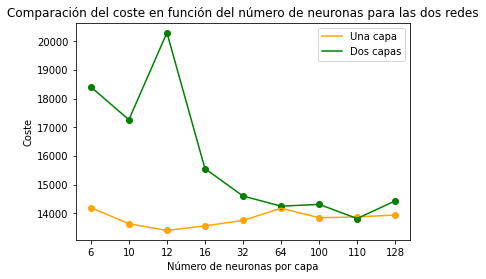

In [ ]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,10)), means_1, color='orange')
ax.plot(list(range(1,10)), means_1, color='orange', label='Una capa')
ax.scatter(list(range(1,10)), means_2, color='green')
ax.plot(list(range(1,10)), means_2, color='green', label='Dos capas')
ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Comparación del coste en función del número de neuronas para las dos redes")
plt.show()

Con los resultados obtenidos se genera la red neuronal que se muestra a continuación:

### 2. Modelo base.

In [ ]:
clf_nn = Sequential()

clf_nn.add(Dense(12, input_shape = (DS2_x_train_scaled.shape[1], ), activation = "relu"))
# Para prevenir el overfitting
clf_nn.add(Dropout(0.5))

# Output de dimensión 2
clf_nn.add(Dense(2, activation = "sigmoid"))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

clf_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0002),
              metrics=['accuracy'])

clf_nn.fit(DS2_x_train_scaled, DS2_y_train_encode,
           class_weight = class_weights_dict,
           batch_size=512,
           epochs= 250, 
           verbose=1,
           validation_data=(DS2_x_test_scaled, DS2_y_test_encode),
           callbacks= [early_stopping]
          )

Epoch 1/250
110/110 [==============================] - 1s 5ms/step - loss: 0.6480 - accuracy: 0.6281 - val_loss: 0.6659 - val_accuracy: 0.9273
Epoch 2/250
110/110 [==============================] - 0s 3ms/step - loss: 0.5754 - accuracy: 0.7738 - val_loss: 0.6355 - val_accuracy: 0.9286
Epoch 3/250
110/110 [==============================] - 0s 3ms/step - loss: 0.5485 - accuracy: 0.8073 - val_loss: 0.5974 - val_accuracy: 0.9372
Epoch 4/250
110/110 [==============================] - 0s 3ms/step - loss: 0.4877 - accuracy: 0.8329 - val_loss: 0.5549 - val_accuracy: 0.9442
Epoch 5/250
110/110 [==============================] - 0s 3ms/step - loss: 0.4579 - accuracy: 0.8654 - val_loss: 0.5169 - val_accuracy: 0.9482
Epoch 6/250
110/110 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8784 - val_loss: 0.4773 - val_accuracy: 0.9519
Epoch 7/250
110/110 [==============================] - 0s 3ms/step - loss: 0.4006 - accuracy: 0.9134 - val_loss: 0.4552 - val_accuracy: 0.9516

Se predicen los resultados utilizando el conjunto de datos de prueba.

In [ ]:
DS2_pred_nn = clf_nn.predict_proba(DS2_x_test_scaled)[:,1] > 0.5

accuracy = accuracy_score(DS2_y_test, DS2_pred_nn)
print("Accuracy: %.2f%% " % (accuracy.mean()*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy: 94.51% 


In [ ]:
# Classification report
print(classification_report(DS2_y_test, DS2_pred_nn))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     15625
        True       0.30      0.98      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.95      0.96     16000



Medidas sobre los conjuntos de entrenamiento y prueba:

In [ ]:
DS2_pred_nn_train = clf_nn.predict_proba(DS2_x_train_scaled)[:,1] > 0.5
print("Pérdida en los datos de entrenamiento:", cost_function(DS2_y_train, DS2_pred_nn_train))
print("Precisión (precision) en los datos de entrenamiento:", np.round(precision_score(DS2_y_train, DS2_pred_nn_train), 4))
print("Sensibilidad (recall) en los datos de entrenamiento:", np.round(recall_score(DS2_y_train, DS2_pred_nn_train), 4))
print("Valor-F1 (F1-score) en los datos de entrenamiento:", np.round(f1_score(DS2_y_train, DS2_pred_nn_train), 4))

print("\nPérdida en los datos de prueba:", cost_function(DS2_y_test, DS2_pred_nn))
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS2_y_test, DS2_pred_nn), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS2_y_test, DS2_pred_nn), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS2_y_test, DS2_pred_nn), 4))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Pérdida en los datos de entrenamiento: 43180
Precisión (precision) en los datos de entrenamiento: 0.1875
Sensibilidad (recall) en los datos de entrenamiento: 0.9362
Valor-F1 (F1-score) en los datos de entrenamiento: 0.3124

Pérdida en los datos de prueba: 12700
Precisión (precision) en los datos de prueba: 0.2967
Sensibilidad (recall) en los datos de prueba: 0.9787
Valor-F1 (F1-score) en los datos de prueba: 0.4553


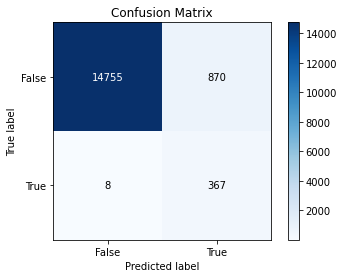

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS2_y_test, DS2_pred_nn, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS2_y_test, DS2_pred_nn))

Coste total del modelo: 12700


La *accuracy* toma un valor bastante alto y el coste total del modelo ha descendido bastante con respecto a la red anterior.

In [ ]:
# Dataframe con las predicciones y la probabilidad predicha
pred = clf_nn.predict_proba(DS2_x_test_scaled)[:,1]

prob_df_nn = pd.DataFrame({"actual": DS2_y_test['class'],
                           "prediction": DS2_pred_nn,
                           "prob": pred,
                           })

prob_df_nn

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


,actual,prediction,prob
0,False,False,0.049447
1,False,False,0.045078
2,False,False,0.133897
3,False,False,0.096722
4,False,False,0.045125
...,...,...,...
15995,False,False,0.125265
15996,False,False,0.044346
15997,False,False,0.125484
15998,False,False,0.046917


Gráfico de distribución de probabilidad.

Este gráfico sirve para identificar si hay un solapamiento entre las distribuciones de clase de la probabilidad predicha para los datos de prueba.

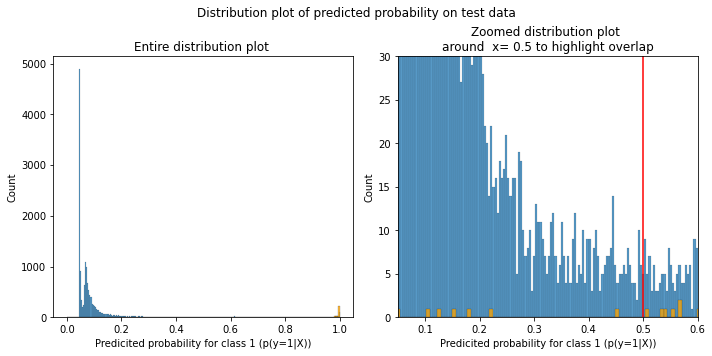

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.histplot(prob_df_nn.loc[prob_df_nn["actual"] == False, "prob"],
             label="0", 
             ax=axes[0], 
             kde=False
            )

sns.histplot(prob_df_nn.loc[prob_df_nn["actual"] == True, "prob"],
             label="1",
             color="orange",
             ax=axes[0],
             kde=False
            )
axes[0].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[0].set_title("Entire distribution plot ")

sns.histplot(prob_df_nn.loc[prob_df_nn["actual"] == False, "prob"],
             label="0", 
             ax=axes[1], 
             kde=False
            )

sns.histplot(prob_df_nn.loc[prob_df_nn["actual"] == True, "prob"],
             label="1",
             color="orange",
             ax=axes[1],
             kde=False
            )

plt.plot([0.5,0.5], [0,30],  color='red')  # Línea vertical para mostrar el umbral por defecto para la asignación de clases
axes[1].set_xlim(0.05 ,0.6)
axes[1].set_ylim(0,30)
axes[1].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[1].set_title("\nZoomed distribution plot \naround  x= 0.5 to highlight overlap")

fig.suptitle("Distribution plot of predicted probability on test data")
plt.tight_layout()

plt.show()

Y se elige el mejor umbral:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


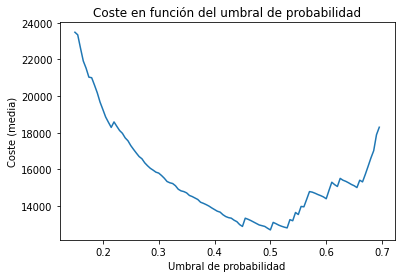

In [ ]:
thresholds = np.arange(0.15,0.7,0.005)
costs = []

for t in thresholds:
  DS2_pred_nn = clf_nn.predict_proba(DS2_x_test_scaled)[:,1] > t
  costs.append(cost_function(DS2_y_test, DS2_pred_nn))
  # print("Coste total del modelo para un umbral de", round(t, 2), ":", cost_function(DS2_y_test, DS2_pred_nn))

# Se representa el coste medio en función del umbral de probabilidad correspondiente
plt.plot(thresholds, costs)
plt.xlabel("Umbral de probabilidad")
plt.ylabel("Coste (media)")
plt.title("Coste en función del umbral de probabilidad")
plt.show()

In [ ]:
# El coste mínimo y su threshold correspondiente son:
print(min(costs), ' ', round(thresholds[np.argmin(costs)], 3))

12700   0.5


El umbral óptimo es 0,5.

Se predicen los resultados utilizando el conjunto de datos de prueba y el umbral óptimo, aunque los datos que se obtendrán serán los mismos que ya se tenían al no haber cambiado el umbral.

In [ ]:
# Umbral
threshold = round(thresholds[np.argmin(costs)], 3)
DS2_pred_nn = clf_nn.predict_proba(DS2_x_test_scaled)[:,1] > threshold

accuracy = accuracy_score(DS2_y_test, DS2_pred_nn)
print("Accuracy: %.2f%% " % (accuracy.mean()*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy: 94.51% 


In [ ]:
# Classification report
print(classification_report(DS2_y_test, DS2_pred_nn))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     15625
        True       0.30      0.98      0.46       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.71     16000
weighted avg       0.98      0.95      0.96     16000



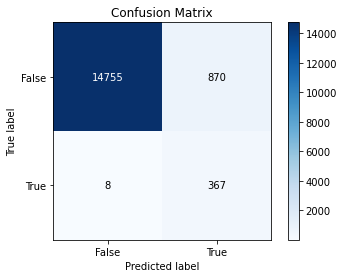

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS2_y_test, DS2_pred_nn, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS2_y_test, DS2_pred_nn))

Coste total del modelo: 12700


Medidas sobre el modelo definitivo:

In [ ]:
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS2_y_test, DS2_pred_nn), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS2_y_test, DS2_pred_nn), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS2_y_test, DS2_pred_nn), 4))
print("Exactitud (accuracy) en los datos de prueba:", np.round(accuracy_score(DS2_y_test, DS2_pred_nn), 4))
print("ROC AUC score en los datos de prueba:", np.round(roc_auc_score(DS2_y_test, DS2_pred_nn), 4))

Precisión (precision) en los datos de prueba: 0.2967
Sensibilidad (recall) en los datos de prueba: 0.9787
Valor-F1 (F1-score) en los datos de prueba: 0.4553
Exactitud (accuracy) en los datos de prueba: 0.9451
ROC AUC score en los datos de prueba: 0.9615


# 3. **DS3**

## 3.1. Red Neuronal

En primer lugar se estandarizan las características utilizando `MinMaxScaler`:

In [ ]:
scaler = MinMaxScaler()
DS3_x_train_scaled = scaler.fit_transform(DS3_x_train)
DS3_x_test_scaled = scaler.transform(DS3_x_test)

Y se transforman los vectores de clase (booleanos) en una matriz de clase binaria.

In [ ]:
DS3_y_train_encode = to_categorical(DS3_y_train)
DS3_y_test_encode = to_categorical(DS3_y_test)

Se estiman los pesos de las clases utilizando `compute_class_weight`:

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(DS3_y_train),
                                                 DS3_y_train['class'])
class_weights_dict = {}
for i in range(len(class_weights)):
  class_weights_dict[i] = class_weights[i]

class_weights_dict

{0: 0.7499413113747585, 1: 1.500234809623582}

### 1. Elección de hiperparámetros.

In [ ]:
layers = [1,2]
neurons = [6, 10, 12, 16, 32, 64, 100, 110, 128]
thresholds = np.arange(0.2,0.65,0.005)

for layer in layers:
  for neuron in neurons:
    
    thres = []
    results = []
    for i in range(8):
      if layer == 1:
        # Una capa
        clf_nn = Sequential()
        clf_nn.add(Dense(neuron, input_shape = (DS3_x_train_scaled.shape[1], ), activation = "relu"))
        clf_nn.add(Dropout(0.5))
        clf_nn.add(Dense(2, activation = "sigmoid"))
      
      else:
        # Dos capas
        clf_nn = Sequential()
        clf_nn.add(Dense(neuron, input_shape = (DS3_x_train_scaled.shape[1], ), activation = "relu"))
        clf_nn.add(Dropout(0.5))
        clf_nn.add(Dense(neuron, activation = "relu"))
        clf_nn.add(Dropout(0.5))
        clf_nn.add(Dense(2, activation = "sigmoid"))
      
      early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
      clf_nn.compile(loss='binary_crossentropy', optimizer=Adam(0.0002), metrics=['accuracy'])
      clf_nn.fit(DS3_x_train_scaled, DS3_y_train_encode,
                 class_weight = class_weights_dict,
                 batch_size=512,
                 epochs= 250,
                 verbose=0,
                 validation_data=(DS3_x_test_scaled, DS3_y_test_encode),
                 callbacks= [early_stopping]
                 )
      
      # Elección del threshold
      costs = []
      for t in thresholds:
        DS3_pred_nn = clf_nn.predict_proba(DS3_x_test_scaled)[:,1] > t
        costs.append(cost_function(DS3_y_test, DS3_pred_nn))
      
      # Umbral
      threshold = round(thresholds[np.argmin(costs)], 3)
      DS3_pred_nn = clf_nn.predict_proba(DS3_x_test_scaled)[:,1] > threshold

      thres.append(threshold)
      res = cost_function(DS3_y_test, DS3_pred_nn)
      results.append(res)
    
    print("Capas:", layer)
    print("Neuronas por capa:", neuron)
    print("Umbrales:", thres)
    print("Resultados:", results)
    print("Mínimo coste (media):", statistics.mean(results))
    print("\n")

Se obtienen los siguientes resultados, que se interpretan de forma totalmente idéntica a los del apartado anterior:

In [ ]:
res_1_6 = [15050, 14210, 13880, 15200, 14760, 15000, 16640, 16390, 15141]
res_1_10 = [15460, 15100, 15780, 15780, 15880, 15850, 16420, 14680, 15618]
res_1_12 = [14870, 16860, 15760, 15410, 14440, 15320, 14950, 14930, 15317]
res_1_16 = [15680, 14960, 14140, 15690, 14370, 15060, 15890, 14920, 15088]
res_1_32 = [14450, 14790, 14860, 15220, 15730, 16830, 14850, 15740, 15308]
res_1_64 = [16220, 15390, 15600, 15500, 14780, 16020, 14580, 15470, 15445]
res_1_100 = [18540, 16000, 16510, 18080, 18180, 16990, 17220, 16080, 17200]
res_1_110 = [16420, 16170, 15810, 15410, 16230, 17570, 16620, 17350, 16447]
res_1_128 = [17430, 17170, 17270, 17770, 15520, 17110, 17440, 18050, 17220]

res_2_6 = [16090, 19370, 19460, 18600, 14870, 19540, 23170, 15200, 18287]
res_2_10 = [14160, 16870, 13060, 18140, 18110, 15800, 15450, 20190, 16472]
res_2_12 = [16720, 18110, 17850, 17400, 15810, 17580, 16250, 15830, 16943]
res_2_16 = [15370, 16960, 16640, 17230, 15440, 15220, 17450, 18590, 16612]
res_2_32 = [16510, 15480, 15180, 17780, 16900, 17350, 17980, 17960, 16892]
res_2_64 = [17230, 17210, 15850, 20530, 16860, 20130, 18310, 16130, 17781]
res_2_100 = [18060, 19810, 21330, 22530, 20680, 21320, 20110, 19340, 20397]
res_2_110 = [20920, 22490, 22360, 20090, 21020, 19730, 19970, 21050, 20953]
res_2_128 = [21190, 20300, 18600, 20220, 20900, 20440, 21330, 20390, 20421]

Se representa el coste en función del número de neuronas para red de una capa. Se muestran en azul los valores obtenidos y en rojo las medias.

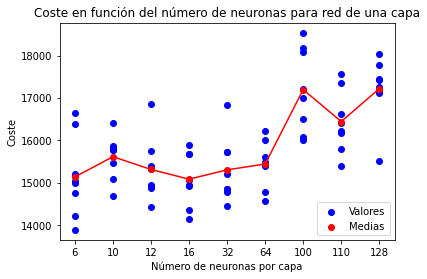

In [ ]:
means_1 = [res_1_6[8], res_1_10[8], res_1_12[8], res_1_16[8],
           res_1_32[8], res_1_64[8], res_1_100[8], res_1_110[8], res_1_128[8]]

fig, ax = plt.subplots()
ax.scatter(list(itertools.repeat(1, 8)), res_1_6[0:8], color='blue')
ax.scatter(list(itertools.repeat(2, 8)), res_1_10[0:8], color='blue')
ax.scatter(list(itertools.repeat(3, 8)), res_1_12[0:8], color='blue')
ax.scatter(list(itertools.repeat(4, 8)), res_1_16[0:8], color='blue')
ax.scatter(list(itertools.repeat(5, 8)), res_1_32[0:8], color='blue')
ax.scatter(list(itertools.repeat(6, 8)), res_1_64[0:8], color='blue')
ax.scatter(list(itertools.repeat(7, 8)), res_1_100[0:8], color='blue')
ax.scatter(list(itertools.repeat(8, 8)), res_1_110[0:8], color='blue')
ax.scatter(list(itertools.repeat(9, 8)), res_1_128[0:8], color='blue', label='Valores')
# Medias
ax.scatter(list(range(1,10)), means_1, color='red', label='Medias')
ax.plot(list(range(1,10)), means_1, color='red')
ax.legend(loc=4)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de neuronas para red de una capa")
plt.show()

Resultados numéricos:

In [ ]:
table = PrettyTable()

table.add_column('Neuronas por capa', [6, 10, 12, 16, 32, 64, 100, 110, 128])
table.add_column('Coste (medio)', means_1)

print(table)

+-------------------+---------------+
| Neuronas por capa | Coste (medio) |
+-------------------+---------------+
|         6         |     15141     |
|         10        |     15618     |
|         12        |     15317     |
|         16        |     15088     |
|         32        |     15308     |
|         64        |     15445     |
|        100        |     17200     |
|        110        |     16447     |
|        128        |     17220     |
+-------------------+---------------+


Se representa el coste en función del número de neuronas para red de dos capas. Se muestran en azul los valores obtenidos y en rojo las medias.

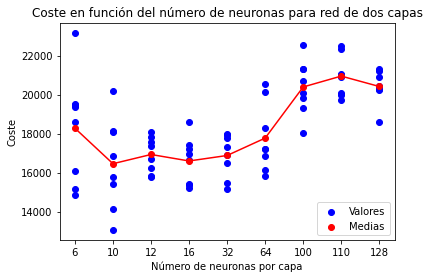

In [ ]:
means_2 = [res_2_6[8], res_2_10[8], res_2_12[8], res_2_16[8],
           res_2_32[8], res_2_64[8], res_2_100[8], res_2_110[8], res_2_128[8]]

fig, ax = plt.subplots()
ax.scatter(list(itertools.repeat(1, 8)), res_2_6[0:8], color='blue')
ax.scatter(list(itertools.repeat(2, 8)), res_2_10[0:8], color='blue')
ax.scatter(list(itertools.repeat(3, 8)), res_2_12[0:8], color='blue')
ax.scatter(list(itertools.repeat(4, 8)), res_2_16[0:8], color='blue')
ax.scatter(list(itertools.repeat(5, 8)), res_2_32[0:8], color='blue')
ax.scatter(list(itertools.repeat(6, 8)), res_2_64[0:8], color='blue')
ax.scatter(list(itertools.repeat(7, 8)), res_2_100[0:8], color='blue')
ax.scatter(list(itertools.repeat(8, 8)), res_2_110[0:8], color='blue')
ax.scatter(list(itertools.repeat(9, 8)), res_2_128[0:8], color='blue', label='Valores')
# Medias
ax.scatter(list(range(1,10)), means_2, color='red', label='Medias')
ax.plot(list(range(1,10)), means_2, color='red')
ax.legend(loc=4)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Coste en función del número de neuronas para red de dos capas")
plt.show()

Resultados numéricos:

In [ ]:
table = PrettyTable()

table.add_column('Neuronas por capa', [6, 10, 12, 16, 32, 64, 100, 110, 128])
table.add_column('Coste (medio)', means_2)

print(table)

+-------------------+---------------+
| Neuronas por capa | Coste (medio) |
+-------------------+---------------+
|         6         |     18287     |
|         10        |     16472     |
|         12        |     16943     |
|         16        |     16612     |
|         32        |     16892     |
|         64        |     17781     |
|        100        |     20397     |
|        110        |     20953     |
|        128        |     20421     |
+-------------------+---------------+


Gráfico con la comparación de las medias para las redes con una y dos capas:

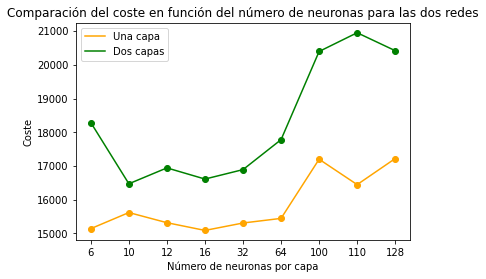

In [ ]:
fig, ax = plt.subplots()
ax.scatter(list(range(1,10)), means_1, color='orange')
ax.plot(list(range(1,10)), means_1, color='orange', label='Una capa')
ax.scatter(list(range(1,10)), means_2, color='green')
ax.plot(list(range(1,10)), means_2, color='green', label='Dos capas')
ax.legend()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [0, 6, 10, 12, 16, 32, 64, 100, 110, 128]
ax.set_xticklabels(labels)

ax.set_xlabel("Número de neuronas por capa")
ax.set_ylabel("Coste")
ax.set_title("Comparación del coste en función del número de neuronas para las dos redes")
plt.show()

Con los resultados obtenidos se genera la red neuronal que se muestra a continuación:

### 2. Modelo base.

In [ ]:
clf_nn_2 = Sequential()

clf_nn_2.add(Dense(16, input_shape = (DS3_x_train_scaled.shape[1], ), activation = "relu"))
# Para prevenir el overfitting
clf_nn_2.add(Dropout(0.5))

# Output de dimensión 2
clf_nn_2.add(Dense(2, activation = "sigmoid"))

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(DS3_y_train),
                                                 DS3_y_train['class'])
class_weights_dict = {}
for i in range(len(class_weights)):
  class_weights_dict[i] = class_weights[i]

class_weights_dict

# (DS3_x_train_scaled.shape[0]/(10*164), ' ', ((DS3_x_train_scaled.shape[1]*2)/3)+2)

{0: 0.7499413113747585, 1: 1.500234809623582}

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

clf_nn_2.compile(loss='binary_crossentropy',
                 # loss=cost_function,
                 optimizer=Adam(0.0002),
                 metrics=['accuracy'])

clf_nn_2.fit(DS3_x_train_scaled, DS3_y_train_encode,
             class_weight = class_weights_dict,
             batch_size=512,
             epochs= 250,
             verbose=1,
             validation_data=(DS3_x_test_scaled, DS3_y_test_encode),
             callbacks= [early_stopping]
             )

Epoch 1/250
163/163 [==============================] - 1s 4ms/step - loss: 0.6683 - accuracy: 0.6080 - val_loss: 0.6158 - val_accuracy: 0.9371
Epoch 2/250
163/163 [==============================] - 0s 3ms/step - loss: 0.5422 - accuracy: 0.8542 - val_loss: 0.5313 - val_accuracy: 0.9436
Epoch 3/250
163/163 [==============================] - 0s 3ms/step - loss: 0.4652 - accuracy: 0.8775 - val_loss: 0.4654 - val_accuracy: 0.9461
Epoch 4/250
163/163 [==============================] - 1s 3ms/step - loss: 0.4158 - accuracy: 0.8896 - val_loss: 0.4227 - val_accuracy: 0.9457
Epoch 5/250
163/163 [==============================] - 0s 3ms/step - loss: 0.3787 - accuracy: 0.9002 - val_loss: 0.3957 - val_accuracy: 0.9446
Epoch 6/250
163/163 [==============================] - 0s 3ms/step - loss: 0.3596 - accuracy: 0.9064 - val_loss: 0.3793 - val_accuracy: 0.9436
Epoch 7/250
163/163 [==============================] - 0s 3ms/step - loss: 0.3442 - accuracy: 0.9103 - val_loss: 0.3654 - val_accuracy: 0.9432

Se predicen los resultados utilizando el conjunto de datos de prueba.

In [ ]:
DS3_pred_nn = clf_nn_2.predict_proba(DS3_x_test_scaled)[:,1] > 0.5

accuracy = accuracy_score(DS3_y_test, DS3_pred_nn)
print("Accuracy: %.2f%% " % (accuracy.mean()*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy: 94.93% 


In [ ]:
# Classification report
print(classification_report(DS3_y_test, DS3_pred_nn))

              precision    recall  f1-score   support

       False       1.00      0.95      0.97     15625
        True       0.31      0.95      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.95      0.72     16000
weighted avg       0.98      0.95      0.96     16000



Medidas sobre los conjuntos de entrenamiento y prueba:

In [ ]:
DS3_pred_nn_train = clf_nn_2.predict_proba(DS3_x_train_scaled)[:,1] > 0.5
print("Pérdida en los datos de entrenamiento:", cost_function(DS3_y_train, DS3_pred_nn_train))
print("Precisión (precision) en los datos de entrenamiento:", np.round(precision_score(DS3_y_train, DS3_pred_nn_train), 4))
print("Sensibilidad (recall) en los datos de entrenamiento:", np.round(recall_score(DS3_y_train, DS3_pred_nn_train), 4))
print("Valor-F1 (F1-score) en los datos de entrenamiento:", np.round(f1_score(DS3_y_train, DS3_pred_nn_train), 4))

print("\nPérdida en los datos de prueba:", cost_function(DS3_y_test, DS3_pred_nn))
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS3_y_test, DS3_pred_nn), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS3_y_test, DS3_pred_nn), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS3_y_test, DS3_pred_nn), 4))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Pérdida en los datos de entrenamiento: 923900
Precisión (precision) en los datos de entrenamiento: 0.9286
Sensibilidad (recall) en los datos de entrenamiento: 0.9347
Valor-F1 (F1-score) en los datos de entrenamiento: 0.9316

Pérdida en los datos de prueba: 16930
Precisión (precision) en los datos de prueba: 0.3104
Sensibilidad (recall) en los datos de prueba: 0.952
Valor-F1 (F1-score) en los datos de prueba: 0.4682


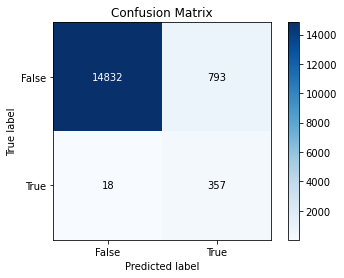

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS3_y_test, DS3_pred_nn, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS3_y_test, DS3_pred_nn))

Coste total del modelo: 16930


La *accuracy* toma un valor bastante alto, pero el coste total del modelo es bastante alto.

In [ ]:
# Dataframe con las predicciones y la probabilidad predicha
pred = clf_nn_2.predict_proba(DS3_x_test_scaled)[:,1]

prob_df_nn_2 = pd.DataFrame({"actual": DS3_y_test['class'],
                             "prediction": DS3_pred_nn,
                             "prob": pred,
                             })

prob_df_nn_2

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


,actual,prediction,prob
0,False,False,0.081632
1,False,False,0.039218
2,False,False,0.131128
3,False,False,0.046248
4,False,False,0.032736
...,...,...,...
15995,False,False,0.036136
15996,False,False,0.037009
15997,False,False,0.017782
15998,False,False,0.052780


Gráfico de distribución de probabilidad.

Este gráfico sirve para identificar si hay un solapamiento entre las distribuciones de clase de la probabilidad predicha para los datos de prueba.

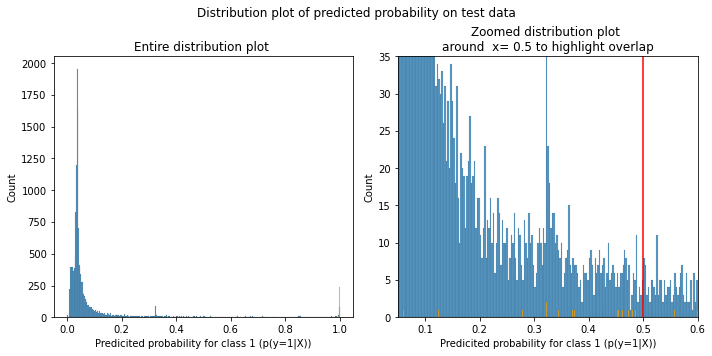

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.histplot(prob_df_nn_2.loc[prob_df_nn_2["actual"] == False, "prob"],
             label="0", 
             ax=axes[0],
             kde=False
            )

sns.histplot(prob_df_nn_2.loc[prob_df_nn_2["actual"] == True, "prob"],
             label="1",
             color="orange",
             ax=axes[0],
             kde=False
            )
axes[0].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[0].set_title("Entire distribution plot ")

sns.histplot(prob_df_nn_2.loc[prob_df_nn_2["actual"] == False, "prob"],
             label="0", 
             ax=axes[1],
             kde=False
            )

sns.histplot(prob_df_nn_2.loc[prob_df_nn_2["actual"] == True, "prob"],
             label="1",
             color="orange",
             ax=axes[1],
             kde=False
            )

plt.plot([0.5,0.5], [0,35],  color='red')  # Línea vertical para mostrar el umbral por defecto para la asignación de clases
axes[1].set_xlim(0.05 ,0.6)
axes[1].set_ylim(0,35)
axes[1].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[1].set_title("\nZoomed distribution plot \naround  x= 0.5 to highlight overlap")

fig.suptitle("Distribution plot of predicted probability on test data")
plt.tight_layout()

plt.show()

Y se elige el mejor umbral:

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


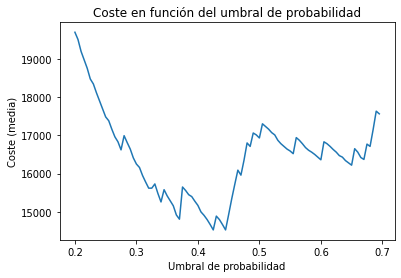

In [ ]:
thresholds = np.arange(0.2,0.7,0.005)
costs = []

for t in thresholds:
  DS3_pred_nn = clf_nn_2.predict_proba(DS3_x_test_scaled)[:,1] > t
  costs.append(cost_function(DS3_y_test, DS3_pred_nn))
  # print("Coste total del modelo para un umbral de", round(t, 2), ":", cost_function(DS3_y_test, DS3_pred_nn))

# Se representa el coste medio en función del umbral de probabilidad correspondiente
plt.plot(thresholds, costs)
plt.xlabel("Umbral de probabilidad")
plt.ylabel("Coste (media)")
plt.title("Coste en función del umbral de probabilidad")
plt.show()

In [ ]:
# El coste mínimo y su threshold correspondiente son:
print(min(costs), ' ', round(thresholds[np.argmin(costs)], 3))

14530   0.425


El umbral óptimo es 0,425.

Se predicen los resultados utilizando el conjunto de datos de prueba y el umbral óptimo.

In [ ]:
# Umbral
threshold = round(thresholds[np.argmin(costs)], 3)
DS3_pred_nn = clf_nn_2.predict_proba(DS3_x_test_scaled)[:,1] > threshold

accuracy = accuracy_score(DS3_y_test, DS3_pred_nn)
print("Accuracy: %.2f%% " % (accuracy.mean()*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Accuracy: 93.98% 


In [ ]:
# Classification report
print(classification_report(DS3_y_test, DS3_pred_nn))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     15625
        True       0.28      0.97      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000



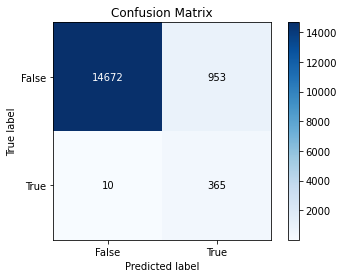

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS3_y_test, DS3_pred_nn, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS3_y_test, DS3_pred_nn))

Coste total del modelo: 14530


Medidas sobre el modelo definitivo:

In [ ]:
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS3_y_test, DS3_pred_nn), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS3_y_test, DS3_pred_nn), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS3_y_test, DS3_pred_nn), 4))
print("Exactitud (accuracy) en los datos de prueba:", np.round(accuracy_score(DS3_y_test, DS3_pred_nn), 4))
print("ROC AUC score en los datos de prueba:", np.round(roc_auc_score(DS3_y_test, DS3_pred_nn), 4))

Precisión (precision) en los datos de prueba: 0.2769
Sensibilidad (recall) en los datos de prueba: 0.9733
Valor-F1 (F1-score) en los datos de prueba: 0.4312
Exactitud (accuracy) en los datos de prueba: 0.9398
ROC AUC score en los datos de prueba: 0.9562


# 4. **Comparación de resultados**

In [ ]:
# Se leen los resultados
results = pd.read_excel('/content/drive/Shareddrives/TFM-JRA/data/resumen.xlsx')
results

,Dataset,Modelo,Umbral,Precision,Recall,F1-score,FN,FP,Coste
0,DS1,Random forest,0.500,0.4583,0.9387,0.6159,23,416,15660
1,DS1,Random forest,0.210,0.3379,0.9813,0.5027,7,721,10710
2,DS1,Red neuronal,0.500,0.7989,0.7733,0.7859,85,73,43230
3,DS1,Red neuronal,0.020,0.4708,0.9253,0.6241,28,390,17900
4,DS2,Random forest,0.500,0.8031,0.6853,0.7396,118,63,59630
5,DS2,Random forest,0.060,0.3518,0.9840,0.5183,6,680,9800
6,DS2,Red neuronal,0.500,0.2967,0.9787,0.4553,8,870,12700
7,DS3,Random forest,0.500,0.4260,0.8747,0.5729,47,442,27920
8,DS3,Random forest,0.160,0.2586,0.9840,0.4095,6,1058,13580
9,DS3,Red neuronal,0.500,0.3104,0.9520,0.4682,18,793,16930


In [ ]:
# Se crea una nueva columna (Modelo_umbral) que indica si el umbral del modelo es el de por defecto (0,5) o el óptimo
results['Modelo_umbral'] = results.apply(lambda row: row.Modelo + '_default' if row.Umbral == 0.5 else row.Modelo + '_thres', axis=1)
results

,Dataset,Modelo,Umbral,Precision,Recall,F1-score,FN,FP,Coste,Modelo_umbral
0,DS1,Random forest,0.500,0.4583,0.9387,0.6159,23,416,15660,Random forest_default
1,DS1,Random forest,0.210,0.3379,0.9813,0.5027,7,721,10710,Random forest_thres
2,DS1,Red neuronal,0.500,0.7989,0.7733,0.7859,85,73,43230,Red neuronal_default
3,DS1,Red neuronal,0.020,0.4708,0.9253,0.6241,28,390,17900,Red neuronal_thres
4,DS2,Random forest,0.500,0.8031,0.6853,0.7396,118,63,59630,Random forest_default
5,DS2,Random forest,0.060,0.3518,0.9840,0.5183,6,680,9800,Random forest_thres
6,DS2,Red neuronal,0.500,0.2967,0.9787,0.4553,8,870,12700,Red neuronal_default
7,DS3,Random forest,0.500,0.4260,0.8747,0.5729,47,442,27920,Random forest_default
8,DS3,Random forest,0.160,0.2586,0.9840,0.4095,6,1058,13580,Random forest_thres
9,DS3,Red neuronal,0.500,0.3104,0.9520,0.4682,18,793,16930,Red neuronal_default


Se crea una *pivot table* para analizar los resultados:

In [ ]:
piv1 = results.pivot('Dataset','Modelo_umbral', 'Coste')
piv1

Modelo_umbral,Random forest_default,Random forest_thres,Red neuronal_default,Red neuronal_thres
Dataset,,,,
DS1,15660.0,10710.0,43230.0,17900.0
DS2,59630.0,9800.0,12700.0,NaN
DS3,27920.0,13580.0,16930.0,14530.0


El valor NaN (*Red neuronal_thres* para DS2) toma el mismo valor que *Red neuronal_default* para DS2. Recordar que en este caso el umbral óptimo era 0,5. Por tanto:

In [ ]:
piv1.iloc[1,3] = piv1.iloc[1,2]
piv1

Modelo_umbral,Random forest_default,Random forest_thres,Red neuronal_default,Red neuronal_thres
Dataset,,,,
DS1,15660.0,10710.0,43230.0,17900.0
DS2,59630.0,9800.0,12700.0,12700.0
DS3,27920.0,13580.0,16930.0,14530.0


Se representa el diagrama de barras de costes - Datasets

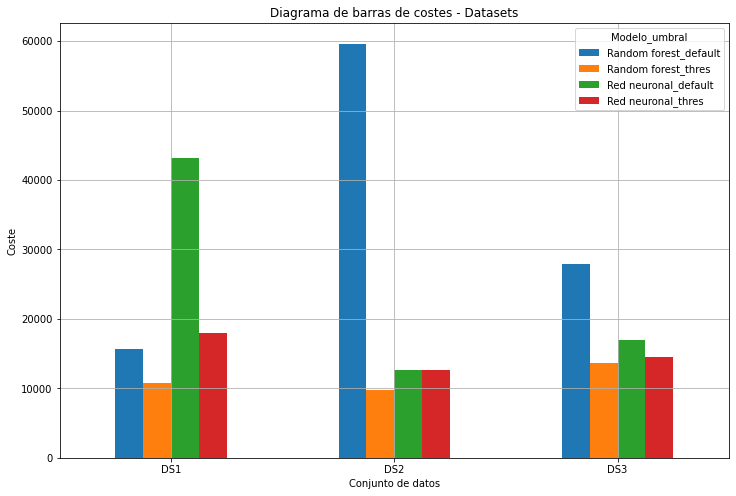

In [ ]:
#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
#Bar-Plot for cost for Imputation method
fig = plt.figure(figsize =(12, 8)) 
ax = fig.add_subplot(111)
piv1.plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Diagrama de barras de costes - Datasets', xlabel='Conjunto de datos', ylabel='Coste' )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

Se crea la *pivot table* traspuesta para terminar de analizar los resultados:

In [ ]:
piv2 = results.pivot('Modelo_umbral', 'Dataset', 'Coste')
piv2

Dataset,DS1,DS2,DS3
Modelo_umbral,,,
Random forest_default,15660.0,59630.0,27920.0
Random forest_thres,10710.0,9800.0,13580.0
Red neuronal_default,43230.0,12700.0,16930.0
Red neuronal_thres,17900.0,NaN,14530.0


Por el mismo motivo que antes:

In [ ]:
piv2.iloc[3,1] = piv2.iloc[2,1]
piv2

Dataset,DS1,DS2,DS3
Modelo_umbral,,,
Random forest_default,15660.0,59630.0,27920.0
Random forest_thres,10710.0,9800.0,13580.0
Red neuronal_default,43230.0,12700.0,16930.0
Red neuronal_thres,17900.0,12700.0,14530.0


Se representa el diagrama de barras de costes - Algoritmos de clasificación

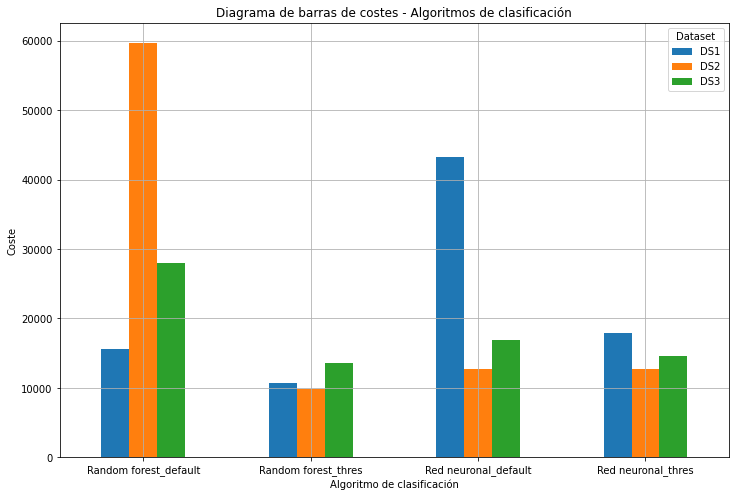

In [ ]:
#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
#Bar-Plot for cost for Imputation method
fig = plt.figure(figsize =(12, 8)) 
ax = fig.add_subplot(111)
piv2.plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Diagrama de barras de costes - Algoritmos de clasificación', xlabel='Algoritmo de clasificación', ylabel='Coste' )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()